In [19]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
from cartopy import crs, feature
import zarr 
import glob
# For polygons
from shapely.geometry import Polygon, Point

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [20]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs',
'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}
#
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])
bathy = xr.open_dataset(path['bat'])

In [21]:
clat = [49.195045]
clon = [-123.301956]
z = 70 # 70 m depth
#
n_hourly = int(5) # amount of particles released every hour through the day
#
release_interval = timedelta(hours=1)
total_release_duration = timedelta(days=1)
#
release_times = [datetime(2022,1,1) + i * release_interval for i in range(int(total_release_duration / release_interval))]
num_releases = len(release_times)
#
lon = [clon[0]] * num_releases * n_hourly
lat = [clat[0]] * num_releases * n_hourly
depth = [z] * num_releases * n_hourly
time = [release_time for release_time in release_times for _ in range(n_hourly)]

In [22]:
time

[datetime.datetime(2022, 1, 1, 0, 0),
 datetime.datetime(2022, 1, 1, 0, 0),
 datetime.datetime(2022, 1, 1, 0, 0),
 datetime.datetime(2022, 1, 1, 0, 0),
 datetime.datetime(2022, 1, 1, 0, 0),
 datetime.datetime(2022, 1, 1, 1, 0),
 datetime.datetime(2022, 1, 1, 1, 0),
 datetime.datetime(2022, 1, 1, 1, 0),
 datetime.datetime(2022, 1, 1, 1, 0),
 datetime.datetime(2022, 1, 1, 1, 0),
 datetime.datetime(2022, 1, 1, 2, 0),
 datetime.datetime(2022, 1, 1, 2, 0),
 datetime.datetime(2022, 1, 1, 2, 0),
 datetime.datetime(2022, 1, 1, 2, 0),
 datetime.datetime(2022, 1, 1, 2, 0),
 datetime.datetime(2022, 1, 1, 3, 0),
 datetime.datetime(2022, 1, 1, 3, 0),
 datetime.datetime(2022, 1, 1, 3, 0),
 datetime.datetime(2022, 1, 1, 3, 0),
 datetime.datetime(2022, 1, 1, 3, 0),
 datetime.datetime(2022, 1, 1, 4, 0),
 datetime.datetime(2022, 1, 1, 4, 0),
 datetime.datetime(2022, 1, 1, 4, 0),
 datetime.datetime(2022, 1, 1, 4, 0),
 datetime.datetime(2022, 1, 1, 4, 0),
 datetime.datetime(2022, 1, 1, 5, 0),
 datetime.da

In [23]:
xr.open_dataset('/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc')['totaldepth']

<xarray.DataArray 'totaldepth' (y: 898, x: 398)> Size: 1MB
[357404 values with dtype=float32]
Dimensions without coordinates: y, x

**Simulation Checking**

Runs:
- 7 days, 2 days of hourly release, 5 particles per hour (done)
- 30 days, 7 days of hourly release, 5 particles per hour (running)

In [24]:
#file_name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_11_days_5_hourly_particles_20220101_1n_20220112_1n.zarr'
#file_name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_44_days_5_hourly_particles_20220101_1n_20220214_1n.zarr'
file_name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_8_days_20_hourly_particles20220101_1n_20220109_1n.zarr'
#file_name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_3_days_5_hourly_particles_20220101_1n_20220104_1n.zarr'
data = xr.open_zarr(file_name, decode_times=True)
depth = data.z/data.fact

In [25]:
number_particles = 5
num_releases = 24
release_times = np.repeat(np.arange(0, 3600*num_releases, 3600), number_particles)
release_times

array([    0,     0,     0,     0,     0,  3600,  3600,  3600,  3600,
        3600,  7200,  7200,  7200,  7200,  7200, 10800, 10800, 10800,
       10800, 10800, 14400, 14400, 14400, 14400, 14400, 18000, 18000,
       18000, 18000, 18000, 21600, 21600, 21600, 21600, 21600, 25200,
       25200, 25200, 25200, 25200, 28800, 28800, 28800, 28800, 28800,
       32400, 32400, 32400, 32400, 32400, 36000, 36000, 36000, 36000,
       36000, 39600, 39600, 39600, 39600, 39600, 43200, 43200, 43200,
       43200, 43200, 46800, 46800, 46800, 46800, 46800, 50400, 50400,
       50400, 50400, 50400, 54000, 54000, 54000, 54000, 54000, 57600,
       57600, 57600, 57600, 57600, 61200, 61200, 61200, 61200, 61200,
       64800, 64800, 64800, 64800, 64800, 68400, 68400, 68400, 68400,
       68400, 72000, 72000, 72000, 72000, 72000, 75600, 75600, 75600,
       75600, 75600, 79200, 79200, 79200, 79200, 79200, 82800, 82800,
       82800, 82800, 82800])

In [26]:
data.obs

<xarray.DataArray 'obs' (obs: 192)> Size: 768B
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191], dtype=int32)
Coordinates:
  * obs      (obs) int32 768B 0 1 2 3 4 5 6 7 ... 185 186 187 188 189 190 191

In [27]:
data.status[:,0].values

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

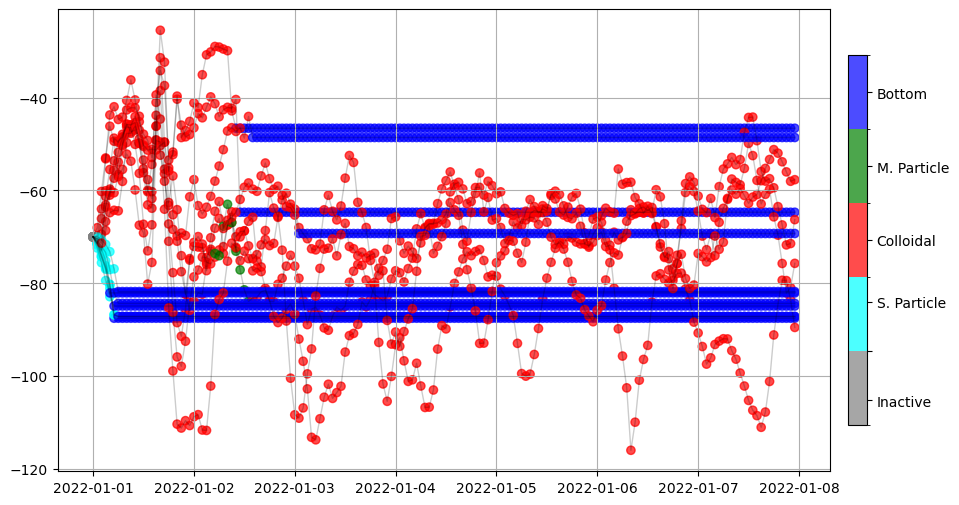

In [37]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
#
status_values = [-1, 1, 2, 3, 4]
colors = ['gray', 'cyan', 'red', 'green', 'blue']  
#
cmap = ListedColormap(colors)
bounds = [-1.5, 0, 1.5, 2.5, 3.5, 4.5]  
norm = BoundaryNorm(bounds, cmap.N)
#
fig, ax = plt.subplots(figsize=(12, 6))
jj = 24*7
for ii in range(15):
    y = data.z[ii, :jj]
    x = data.time[ii, :jj]
    z = data.status[ii, :jj]
    ax.plot(x, -y, '-k', alpha=.2, linewidth=1)
    s = ax.scatter(x, -y, c=z, cmap=cmap, norm=norm, alpha = .7)
#
ax.grid()
#
cbar = fig.colorbar(s, ax=ax, orientation='vertical', pad=0.02, shrink=0.8,
                    ticks=[-1, 0, 1, 2, 3, 4])
cbar.ax.set_yticklabels(['Inactive','','S. Particle', 'Colloidal', 'M. Particle', 'Bottom'])
#
plt.show()

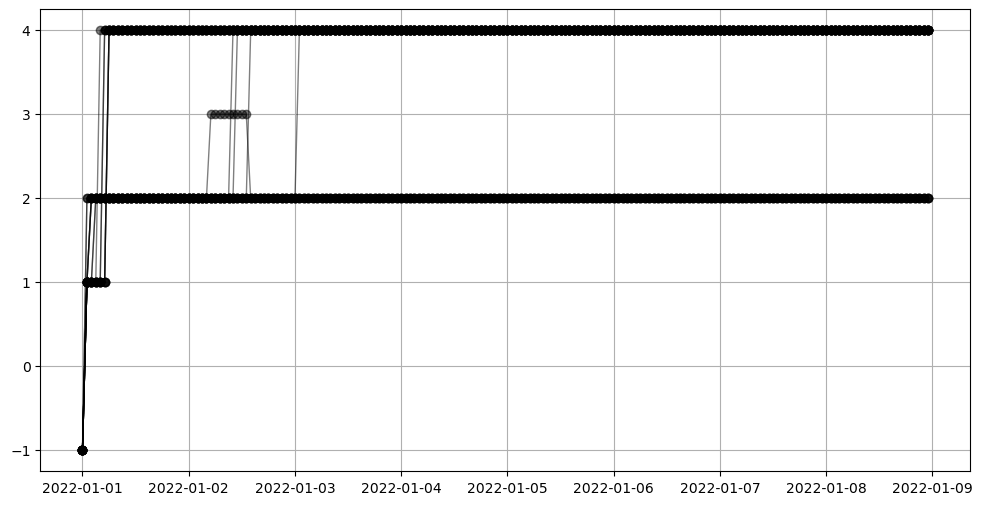

In [30]:
fig, ax = plt.subplots(figsize = (12,6))
for ii in range(15):
    y = data.status[ii, :]
    x = data.time[ii, :]
    ax.plot(x, y, '-o', alpha = .5, linewidth = 1, c='k')
ax.grid() 

/tmp/ipykernel_1992452/390512203.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)


(48.495045, 49.895045)

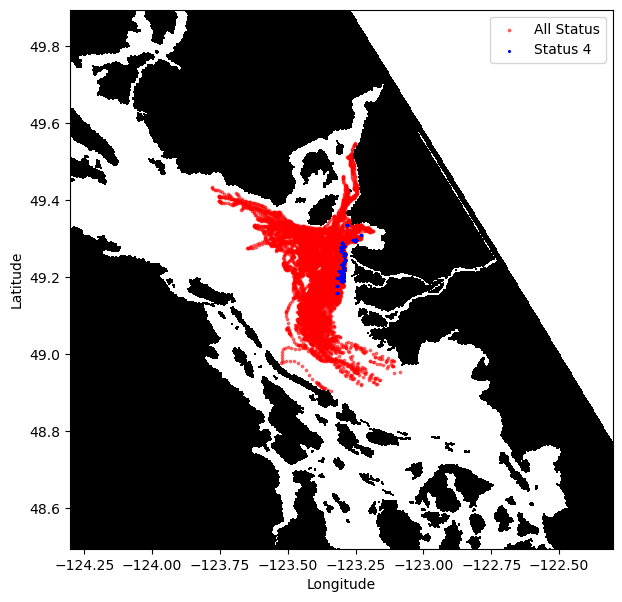

In [35]:
fig, ax = plt.subplots(figsize=(7,7))
#
colors = [(0, 0, 0, 1),  # Black for land (1)
          (0, 0, 0, 0)]  # Transparent for water (0)
cmap = ListedColormap(colors)
#
#ax.scatter(data.where(data.status == -1).lon, data.where(data.status == -1).lat, c='r', s = 3)
ax.scatter(data.lon, data.lat, c='r', s = 3, alpha=.5, label = 'All Status')
ax.scatter(data.where(data['status'] == 4).lon, data.where(data['status'] == 4).lat, c='b', s = 1.5, label = 'Status 4')

ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
#ax.scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
ax.legend()
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_xlim([clon[0] - 1, clon[0] + 1])
ax.set_ylim([clat[0] - .7, clat[0] + .7])

testing stuff

In [189]:
clat = [49.195045]
clon = [-123.301956]
z = 70 # 70 m depth
#
n_hourly = int(5) # amount of particles released every hour through the day
#
release_interval = timedelta(hours=1)
total_release_duration = timedelta(days=1)
#
release_times = [datetime(2022,1,1) + i * release_interval for i in range(int(total_release_duration / release_interval))]
num_releases = len(release_times)
#
lon = [clon[0]] * num_releases * n_hourly
lat = [clat[0]] * num_releases * n_hourly
depth = [z] * num_releases * n_hourly
time = [release_time for release_time in release_times for _ in range(n_hourly)]

In [190]:
array = np.zeros(num_releases * n_hourly)#
for i in range(0,len(array)):
    value = random.random()
    if value <= 0.75: # 75% goes to status 1
        array[i] = 1
    else: # the other 25% goes to status 2
        array[i] = 2

In [193]:
status = array

In [53]:
days_release = 1
values = np.arange(-1800, 23 * 3600 * days_release, 3600 * 2) # 2 of 2 hours per release
repeats = 5
hour_times = np.repeat(values, repeats)

In [58]:
valores = np.arange(0, 24 * days_release) # 2 of 2 hours per release
reps = 5
markers = np.repeat(valores, reps)

In [ ]:
limit_begin_end = int(timedelta(days=2).total_seconds()/(60*60))
print(limit_begin_end)

In [ ]:
data_analysis = data.isel(obs=slice(limit_begin_end, -limit_begin_end))
tt = []
for i in range(0,len(data_analysis.obs)):
    tt.append(np.min(data_analysis.time[0,0].values).astype('datetime64[s]').tolist() + i*timedelta(hours=1))
times = np.tile(tt, (len(data_analysis.trajectory), 1))
#
data_analysis['time'].values = times

In [20]:
def particles_concentration_map(lons, lats, mask=mask, num_lon=30, num_lat=40):
    # Define lon and lat lenght 
    longitudes = np.linspace(mask['nav_lon'].min(), mask['nav_lon'].max(), num_lon + 1)
    latitudes = np.linspace(mask['nav_lat'].min(), mask['nav_lat'].max(), num_lat + 1)
    #
    # Particle positions into bins
    lon_indices = np.digitize(lons, longitudes) - 1 
    lat_indices = np.digitize(lats, latitudes) - 1
    #
    amount = np.zeros((num_lon, num_lat))
    #
    valid_mask = (lon_indices >= 0) & (lon_indices < num_lon) & (lat_indices >= 0) & (lat_indices < num_lat)
    lon_indices, lat_indices = lon_indices[valid_mask], lat_indices[valid_mask]
    # Count particles 
    indices = np.ravel_multi_index((lon_indices, lat_indices), dims=(num_lon, num_lat))
    counts = np.bincount(indices, minlength=num_lon * num_lat).reshape((num_lon, num_lat))
    #
    amount[:counts.shape[0], :counts.shape[1]] = counts
    #
    return pd.DataFrame(amount)

In [21]:
concentration_B = particles_concentration_map(lons=data.where(data['status'] == 4)['lon'], lats=data.where(data['status'] == 4)['lat'])
concentration_MP = particles_concentration_map(lons=data.where(data['status'] == 3)['lon'], lats=data.where(data['status'] == 3)['lat'])
concentration_C = particles_concentration_map(lons=data.where(data['status'] == 2)['lon'], lats=data.where(data['status'] == 2)['lat'])
concentration_SP = particles_concentration_map(lons=data.where(data['status'] == 1)['lon'], lats=data.where(data['status'] == 1)['lat'])
total_concentration = particles_concentration_map(lons=data['lon'], lats=data['lat'])

In [22]:
data1 = data
#
colloidal = []
marine = []
bottom = []
sewage = []
total = []
#
for i in range(len(data1.obs)):
    len_1 = len(np.where(np.isfinite(data1.status[:, i]) & (data1.status[:, i] == 1.))[0])
    len_2 = len(np.where(np.isfinite(data1.status[:, i]) & (data1.status[:, i] == 2.))[0])
    len_3 = len(np.where(np.isfinite(data1.status[:, i]) & (data1.status[:, i] == 3.))[0])
    len_4 = len(np.where(np.isfinite(data1.status[:, i]) & (data1.status[:, i] == 4.))[0])
    #
    len_T = np.count_nonzero(~np.isnan(data1.status[:, i]))
    #
    sewage.append(len_1)
    colloidal.append(len_2)
    marine.append(len_3)
    bottom.append(len_4)
    total.append(len_T)
#    
proportion_colloidal = np.array(colloidal)/np.array(total)
proportion_marine = np.array(marine)/np.array(total)
proportion_bottom = np.array(bottom)/np.array(total)
proportion_sewage = np.array(sewage)/np.array(total)

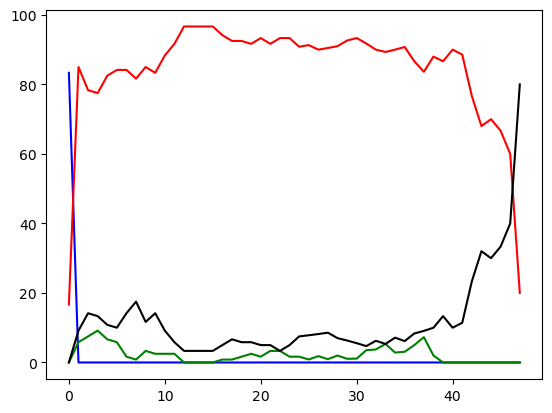

In [23]:
plt.plot(proportion_sewage*100, 'b')
plt.plot(proportion_colloidal*100, 'r')
plt.plot(proportion_marine*100, 'g')
plt.plot(proportion_bottom*100, 'k')

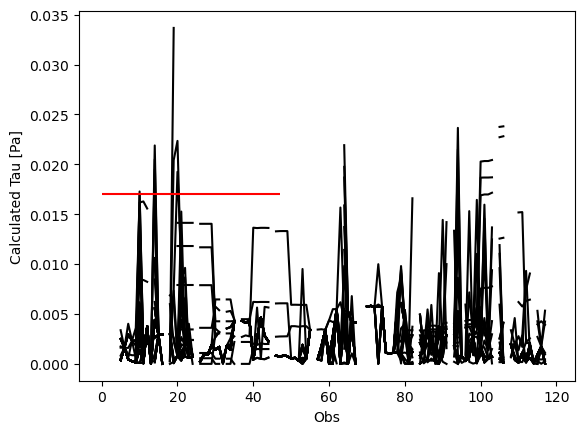

In [24]:
plt.plot(data.h_vel, 'k')
#plt.axhline(y=5*10e-15, color = 'r')
plt.ylabel('Calculated Tau [Pa]')
plt.xlabel('Obs')
plt.hlines(y=0.017, xmin=0, xmax = data.obs[-1], colors = 'r')

$$u^{*} = \frac{U \cdot k}{ln(\frac{z}{z_{*}})}$$

$$\tau = u*^{2} \cdot \rho $$

NOTE: Super small values of Tau from the calculations inside the resuspension Kernel.
    
    - Reasons:
- U and V velocities, with the correction of bat_particle, they now decrease significantly (as they should). Therefore, since we are calculating the magnitude, which involves squares and square roots, this becomes even smaller. 

- Now, with the same correction for the variable e3t, the grid cell sizes are now bigger. Therefore, the ln() function increase and bigger values are in the denominator of u*


So, this correction now decreases and increases the numerator and denominator respectively, leading to a super small value of Tau

In [26]:
clat = [49.195045]
clon = [-123.301956]
num_lon = 30
num_lat = 40
longitudes = np.linspace(mask['nav_lon'].min(), mask['nav_lon'].max(), num_lon+1)
latitudes = np.linspace(mask['nav_lat'].min(), mask['nav_lat'].max(), num_lat+1)

/tmp/ipykernel_2586592/3649544219.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
/tmp/ipykernel_2586592/3649544219.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0,0].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
/tmp/ipykernel_2586592/3649544219.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, ple

Text(0.5, 0, 'Longitude')

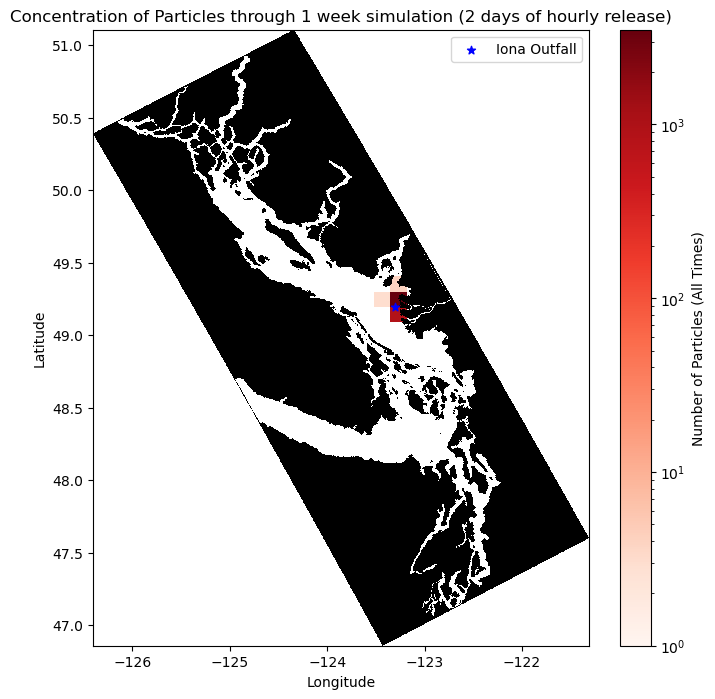

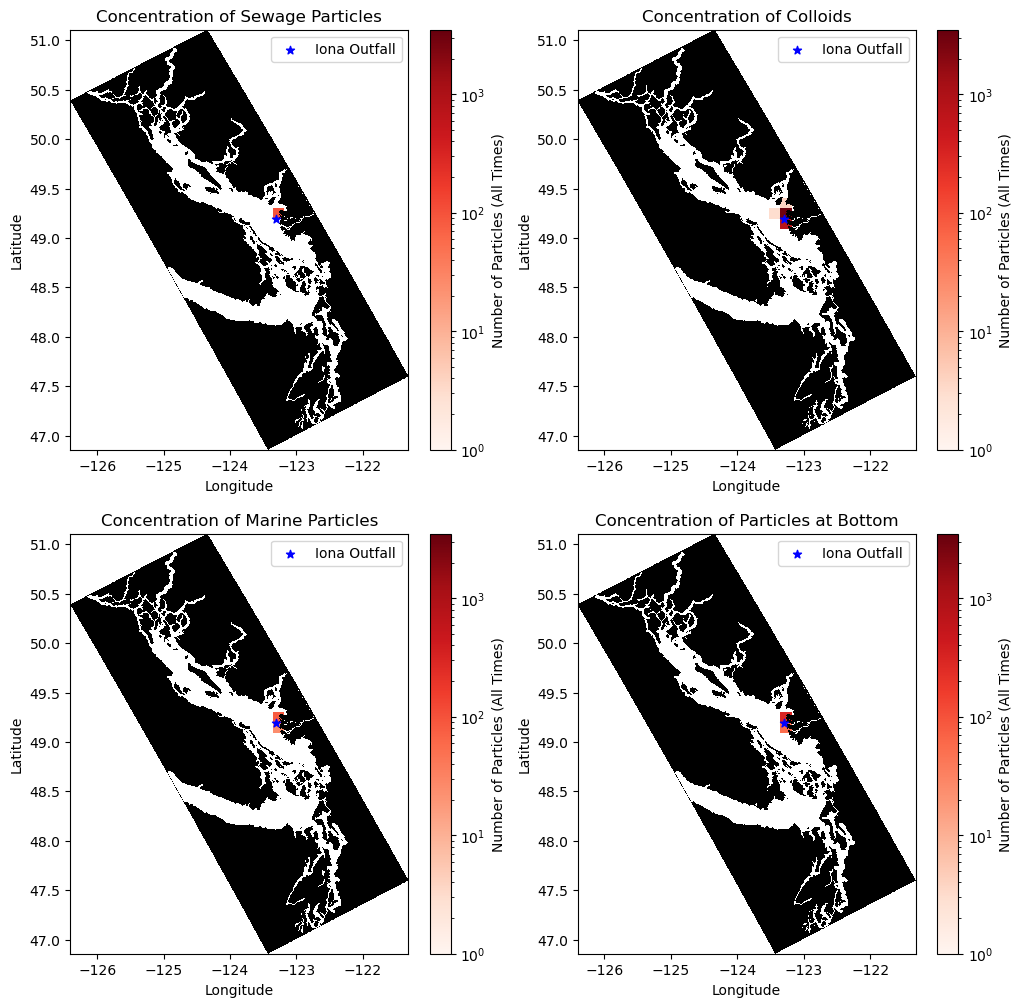

In [27]:
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
#
colors = [(0, 0, 0, 1),  # Black for land (1)
          (0, 0, 0, 0)]  # Transparent for water (0)
cmap = ListedColormap(colors)
#
fig, ax = plt.subplots(figsize=(8,8))
c = ax.pcolormesh(longitudes, latitudes, total_concentration.T, cmap='Reds', norm=LogNorm(vmin=total_concentration.min().min()+10e-1, vmax=total_concentration.max().max()))
ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
#ax.set_xlim(0,tmask.x[-1])
#ax.set_ylim(0, tmask.y[-1])
#
ax.scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
#
fig.colorbar(c, ax=ax, label="Number of Particles (All Times)")
ax.legend()
#
ax.set_title('Concentration of Particles through 1 week simulation (2 days of hourly release)')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
#
fig, ax = plt.subplots(2,2,figsize=(12,12))
#
sewage = ax[0,0].pcolormesh(longitudes, latitudes, concentration_SP.T, cmap='Reds', norm=LogNorm(vmin=concentration_SP.min().min()+1, vmax=total_concentration.max().max()))
ax[0,0].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[0,0].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(sewage, ax=ax[0,0], label="Number of Particles (All Times)")
ax[0,0].legend()
ax[0,0].set_title('Concentration of Sewage Particles')
ax[0,0].set_ylabel('Latitude')
ax[0,0].set_xlabel('Longitude')
#
colloids = ax[0,1].pcolormesh(longitudes, latitudes, concentration_C.T, cmap='Reds', norm=LogNorm(vmin=concentration_C.min().min()+1, vmax=total_concentration.max().max()))
ax[0,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[0,1].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(sewage, ax=ax[0,1], label="Number of Particles (All Times)")
ax[0,1].legend()
ax[0,1].set_title('Concentration of Colloids')
ax[0,1].set_ylabel('Latitude')
ax[0,1].set_xlabel('Longitude')
#
marine = ax[1,0].pcolormesh(longitudes, latitudes, concentration_MP.T, cmap='Reds', norm=LogNorm(vmin=concentration_MP.min().min()+1, vmax=total_concentration.max().max()))
ax[1,0].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[1,0].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(sewage, ax=ax[1,0], label="Number of Particles (All Times)")
ax[1,0].legend()
ax[1,0].set_title('Concentration of Marine Particles')
ax[1,0].set_ylabel('Latitude')
ax[1,0].set_xlabel('Longitude')
#
bottom = ax[1,1].pcolormesh(longitudes, latitudes, concentration_B.T, cmap='Reds', norm=LogNorm(vmin=concentration_B.min().min()+1, vmax=total_concentration.max().max()))
ax[1,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[1,1].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(bottom, ax=ax[1,1], label="Number of Particles (All Times)")
ax[1,1].legend()
ax[1,1].set_title('Concentration of Particles at Bottom')
ax[1,1].set_ylabel('Latitude')
ax[1,1].set_xlabel('Longitude')
